# Bias, Variance, and Model Validation

![validation gif from giphy](https://media.giphy.com/media/242wLqQerWkxd6GgHB/giphy.gif)

## Learning Objectives

- Define _bias_ and _variance_ in the context of machine learning
- Recognize how bias and variance are related to under- and over-fitting
- Summarize why validation is important
- Describe how a train-test split works
- Apply a train-test split to a dataset using sklearn

Bonus:
- Explain why k-fold cross validation is often more robust than a single train-test split
- Apply k-fold cross validation to a dataset using sklearn

To recap what we've done so far this week, and especially to reiterate what we did yesterday, let's look at some generated data and see what adding polynomial terms does to our model.

In [1]:
# Imports
import pandas as pd
import numpy as np
# Setting random seed for reproducibility
np.random.seed(1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# 150 samples from uniform distribution between -2pi and 2pi

x = np.random.uniform(-2*np.pi, 2*np.pi, 150)

# Creating target (y) - so we know the true relationship between x and y
# But - adding some noise (error) with 'np.random'

y = np.sin(x) + np.random.normal(loc=0, scale=0.4, size=len(x))

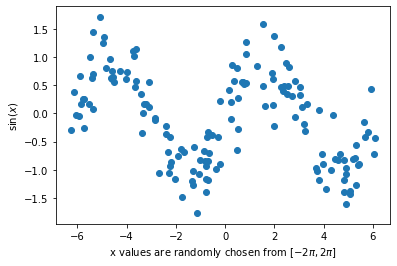

In [3]:
# Visualize it
plt.scatter(x, y)

plt.ylabel('$\sin(x)$')
plt.xlabel('x values are randomly chosen from $[-2\pi, 2\pi]$')
plt.show()

In [4]:
# Fitting a linear model
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
# Grabbing the predicted values
y_pred = lr.predict(x.reshape(-1, 1))

In [6]:
# Scoring our model
print(f"R2 Score: {r2_score(y, y_pred)}")

R2 Score: 0.13519811764759415


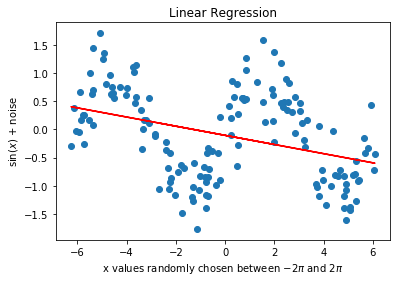

In [7]:
# Visualize it
plt.scatter(x, y) # original data

plt.plot(x, y_pred, c='red') # predicted values

plt.ylabel('$\sin(x)$ + noise')
plt.xlabel('x values randomly chosen between $-2\pi$ and $2\pi$')
plt.title("Linear Regression")

plt.show()

Is this a good model? Well - of course not. It is what we would call **underfit** - it is not complex enough to accurately capture the pattern and predict the target.

Let's try again, but now with polynomials!

In [8]:
# For this, we'll need some helper functions
# Shoutout to Andy for sending me these

def create_poly_dataset(x, degree):
    """
    returning dataset with the given polynomial degree
    """
    # Instantiate the PolynomialFeatures object with given 'degree'
    poly = PolynomialFeatures(degree=degree)

    # Now transform data to create higher order features
    new_data = poly.fit_transform(x.reshape(-1, 1))
    return new_data

def fit_linear_model(data, y):
    """
    fitting a linear model and printing model details
    """
    np.set_printoptions(precision=4, suppress=True)

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    lr = LinearRegression(fit_intercept=False)
    lr.fit(data, y)
    print("-"*13)
    print("Coefficients: ", lr.coef_)
    y_pred = lr.predict(data)
    print(f"R-Squared: {lr.score(data, y):.3f}")
    return lr

def plot_predict(x, y, model):
    """
    plotting predictions against true values
    """
    plt.scatter(x, y, label='true')
    x_pred = np.linspace(x.min(), x.max(), 100)
    
    # visualize beyond this x range by uncommenting below:
#     extra = x.ptp() * .2
#     x_pred = np.linspace(x.min() - extra, x.max() + extra, 100)

    plt.plot(x_pred, model.predict(create_poly_dataset(x_pred, len(model.coef_)-1)),
             label='predicted', c='red')

    if len(model.coef_) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms \n (no slope)")
    elif (len(model.coef_) - 1) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Term")
    else:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms")

    plt.legend()
    plt.show()
    return

-------------
Coefficients:  [-0.0994]
R-Squared: 0.000


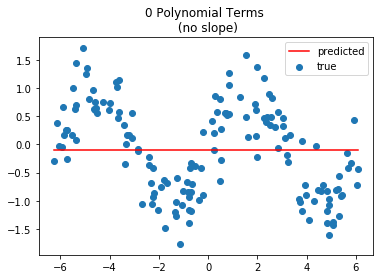

-------------
Coefficients:  [-0.1054 -0.0814]
R-Squared: 0.135


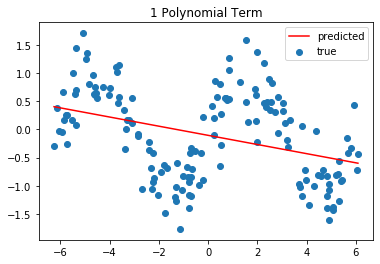

-------------
Coefficients:  [-0.1265 -0.0811  0.0016]
R-Squared: 0.136


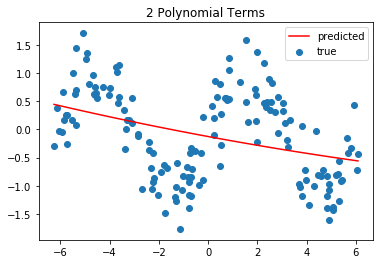

-------------
Coefficients:  [-0.103   0.0832 -0.0008 -0.007 ]
R-Squared: 0.232


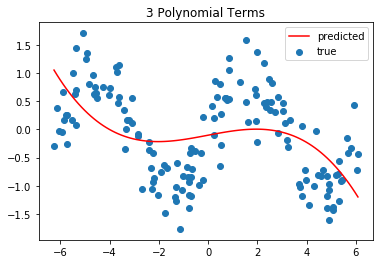

-------------
Coefficients:  [-0.1513  0.6129  0.0149 -0.0714 -0.0003  0.0015]
R-Squared: 0.687


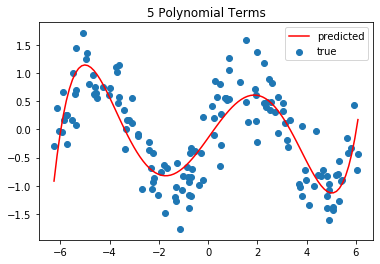

-------------
Coefficients:  [-0.1646  0.9111  0.0319 -0.1402 -0.0017  0.0054  0.     -0.0001]
R-Squared: 0.761


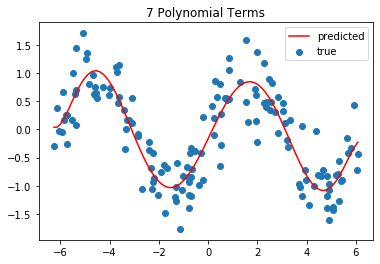

-------------
Coefficients:  [-0.1716  0.9651  0.0424 -0.1604 -0.0032  0.0074  0.0001 -0.0001 -0.
  0.    ]
R-Squared: 0.763


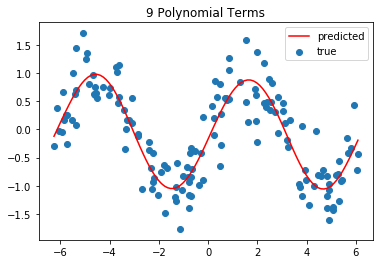

-------------
Coefficients:  [-0.12    1.0427 -0.031  -0.195   0.0133  0.0103 -0.0011 -0.      0.
 -0.     -0.      0.     -0.     -0.    ]
R-Squared: 0.775


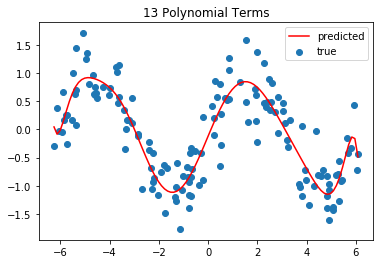

-------------
Coefficients:  [-0.1118  1.2978 -0.0199 -0.5794 -0.0209  0.1608  0.0122 -0.0258 -0.0021
  0.0023  0.0002 -0.0001 -0.      0.      0.     -0.     -0.      0.
  0.    ]
R-Squared: 0.795


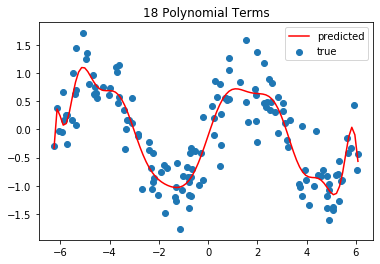

In [9]:
# visualizing an assortment of polynomial degrees
# can visualize each sequential polynomial with `range(n)`
for i in [0, 1, 2, 3, 5, 7, 9, 13, 18]:
    xi = create_poly_dataset(x, i)
    plot_predict(x, y, fit_linear_model(xi, y))

So... which one is best?

- it depends



-------

## The Bias-Variance Trade Off

<img alt="original image from https://rmartinshort.jimdofree.com/2019/02/17/overfitting-bias-variance-and-leaning-curves/" src="images/underfit-goodfit-overfit.png" width=750, height=350>  

Remember - by modeling, we're assuming that there is some relationship between our X variables (the features in our dataset) and our y variable (the target). Thus, there is some underlying '_true_' function that captures the relationship between X and y, which we are trying to find by modeling. Of course, the actual relationship may be quite complex and not wholly represented in our data - our approximation, aka the model we create, is likely only a simplified estimator of whatever our '_true_' function actually would look like.

**Bias**: Error introduced by approximating a real-life problem (which may be extremely complicated) by a much simpler model (because the model is too simple to capture the underlying pattern)

**Variance**: Amount by which our model would change if we estimated it using a different training dataset (because the model is over-learning from the training data)

**Representation:**

<img alt="from https://hsto.org/files/281/108/1e9/2811081e9eda44d08f350be5a9deb564.png" src="images/bias-variance.png/" width=350, height=350>

## How To Minimize Bias and Variance

Good news! There are tried and true methods to reducing both bias and variance in our modeling process. Testing different models, trying models on different slices of data, transforming or engineering features - all of these things have a role to play in creating better, more robust models.

In particular, we've learned so far that we can evaluate the performance of our models, using a scoring metric, which will help us catch if a model is underfit - if it's performing quite poorly, it probably isn't capturing the relationship in our data! 

But what about overfitting?

## Model Validation

Let's say you have a dataframe, with some number of rows of data, and that's all you have available to you. The hope is that you can train a model on this data that can then be used to make predictions about new data that comes in. You want your model to generalize well and work on this incoming data - not too complex from learning all the details/noise from the data, but also not so simple that the model is useless. How do we do that?

<img alt="I Love Lucy shrug gif from Giphy" src="https://media.giphy.com/media/JRhS6WoswF8FxE0g2R/giphy.gif" width=350, height=350>

### Train-Test Split

The idea: don't train your model on ALL of your data, but keep some of it in reserve to test on, in order to simulate how it will work on new/incoming data.

#### Example:

<img alt="original image from https://www.dataquest.io/wp-content/uploads/kaggle_train_test_split.svg plus some added commentary" src="images/traintestsplit_80-20.png" width=850, height=150>  

Note - here, it looks like we're just taking the tail end of the dataset and setting it aside. In practice (most of the time), the split will randomly choose which rows are in the train vs. test sets.

How does this fight against overfitting? By witholding data from the training process, we are testing whether the model actually _generalizes_ well. If it does poorly on the test set, it's a good sign that our model learned too much noise from the train set and is overfit! 

![arrested development gif, found by Andy](https://heavy.com/wp-content/uploads/2013/05/tumblr_mjm9fqhrle1rvnnvyo6_250.gif)

#### Practice:

Let's go back to our Credit data, where we are trying to predict `balance`.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [10]:
df = pd.read_csv('data/Credit.csv',
                 usecols=['Income', 'Limit', 'Rating',
                          'Cards', 'Age', 'Balance'])
df.head()

,Income,Limit,Rating,Cards,Age,Balance
0,14.891,3606,283,2,34,333
1,106.025,6645,483,3,82,903
2,104.593,7075,514,4,71,580
3,148.924,9504,681,3,36,964
4,55.882,4897,357,2,68,331


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
Income     400 non-null float64
Limit      400 non-null int64
Rating     400 non-null int64
Cards      400 non-null int64
Age        400 non-null int64
Balance    400 non-null int64
dtypes: float64(1), int64(5)
memory usage: 18.9 KB


In [12]:
df.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Balance'], dtype='object')

In [13]:
# Define our X and y

X_cols = [c for c in df.columns.to_list() if c not in ['Balance']]

X = df[X_cols]
y = df['Balance']

In [15]:
# Train test split here!
# Set test_size = .33
# Set random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

What did that do?

In [16]:
X_train.shape

(268, 5)

In [17]:
X_test.shape

(132, 5)

In [18]:
len(X_train + X_test) == len(X)

True

In [20]:
X_train.head()

,Income,Limit,Rating,Cards,Age
258,41.400,2561,215,2,36
177,22.379,3965,292,2,34
119,23.012,1410,137,3,81
194,30.406,2120,181,2,79
229,69.943,7555,547,3,76


In [27]:
X_train.shape

(268, 5)

Now let's put our train/test split into practice:

In [21]:
# Instantiate a scaler to scale our data
# Let's use Standard Scaler here

scaler = StandardScaler()

In [23]:
# Fit our scaler - ON THE TRAINING DATA!!
# Then transform both train and test 

X_train_scaled = scaler.fit_transform(X_train)
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [24]:
# Instantiate an sklearn linear model

lr = LinearRegression()

In [28]:
# Fit your model - ON THE TRAINING DATA!!

lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
# Grab predictions for train and test set

y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

In [30]:
# How'd we do?

print(f"Train R2 Score: {r2_score(y_train, y_pred_train)}")
print(f"Test R2 Score: {r2_score(y_test, y_pred_test)}")

Train R2 Score: 0.886882050887701
Test R2 Score: 0.8500179616615862


Evaluate!

- 


In [35]:
# Single variable example

X_single = df['Income']
y = df['Balance']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_single, y, test_size=0.33, random_state=42)

In [41]:
scaler = StandardScaler()
X_s_train = scaler.fit_transform(X_train.values.reshape(-1, 1))
X_s_test = scaler.transform(X_test.values.reshape(-1, 1))

lr = LinearRegression()
lr.fit(X_s_train, y_train)
lr.score(X_s_test, y_test)

0.09186644925972041

### But Wait... There's More!

Let's change something and see what happens:

In [42]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33, 
                                                        random_state=n) # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    
    y_pred_train = lr.predict(X_train_scaled)
    y_pred_test = lr.predict(X_test_scaled)
    
    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_pred_train)}")
    print(f"Test R2 Score: {r2_score(y_test, y_pred_test)}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.8827743316528185
Test R2 Score: 0.865687168763958
-----
Random Seed: 1
Train R2 Score: 0.8749498976551126
Test R2 Score: 0.8821530969365607
-----
Random Seed: 2
Train R2 Score: 0.8735830572848693
Test R2 Score: 0.883996868696491
-----
Random Seed: 3
Train R2 Score: 0.8995454439886379
Test R2 Score: 0.8337130318588979
-----
Random Seed: 4
Train R2 Score: 0.875437224172817
Test R2 Score: 0.8781140021225986
-----
Random Seed: 5
Train R2 Score: 0.8916801642210901
Test R2 Score: 0.8466484849652411
-----
Random Seed: 6
Train R2 Score: 0.8642965940479224
Test R2 Score: 0.8996957762399631
-----
Random Seed: 7
Train R2 Score: 0.8877156457889817
Test R2 Score: 0.8555914480287858
-----
Random Seed: 8
Train R2 Score: 0.8747040662140566
Test R2 Score: 0.8812357648090403
-----
Random Seed: 9
Train R2 Score: 0.8776062868954854
Test R2 Score: 0.8768879053835608
-----


What's happening here? All we're doing is changing our `random_seed` - why is that having such an impact on our model's scores? Some models appear overfit, some don't - and for some, the test score is **better** than our train score!

In [43]:
df.shape

(400, 6)

### K-Fold Cross-Validation

Sometimes, random chance means your training data isn't representative, or includes wacky data like all of our outliers. So, why do just one train-test split when you can do `k` number of them!

![cross validation image from kaggle: https://www.kaggle.com/alexisbcook/cross-validation](images/cross-validation.png)

The good news is, we'll never actually have to do this by hand - `sklearn` will handle it for us!

Documentation: https://scikit-learn.org/stable/modules/cross_validation.html

In [46]:
# Scale our data

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [47]:
# Instantiate a fresh linear regression model
lr = LinearRegression()

In [52]:
# Let's use cross_val_score
# Set cv = 5

scores = cross_val_score(lr, X_scaled, y, cv=5, scoring="r2")

In [53]:
# Look at the test scores across our folds
scores

array([0.8603, 0.8555, 0.8882, 0.8733, 0.8846])

In [55]:
# Print it nicely
print(f"Scores: {scores.mean():.3f} +/- {scores.std():.3f}")

Scores: 0.872 +/- 0.013


Why show the standard deviation of scores here? I want some measure of the variance among my scores, so I can tell how different my scores were based on different breakdowns of the training data.

If I made a change to my model and the average of my cross-validated scores stayed about the same, but the variance among those scores decreased, that's a better, more generalizable model than before!

### Additional Resources:

- [Great bias/variance infographic](https://elitedatascience.com/bias-variance-tradeoff) from Elite Data Science